#**Flight Delay and Cancellation Analysis from 2.9 Million Flights (EDA)**

**Author:** `Panagiotis Kardatos, Mathematician`

**Date:** `Late October 2025`

The main objective of this data analysis is to explore patterns in flight delays and cancellations between 2019-2023. We are focusing on:

*  How delays evolved over time
*  Which airlines and airports have the highest delay or cancellation rates
*  Time periods most associated with delays

##**Step 1: Data Import and Setup**
At this step:

*  We will install and import all the libraries required for this project.

*  We will download data and get them into chunks due to the extreme size of this dataset.

We begin by installing `kagglehub` to get access and download the dataset directly and `cudf` a GPU dataframe library to utilize high computational GPU speeds where is possible then we will import the libraries.

In [1]:
#Libraries Installation
!pip install kagglehub
!pip install cudf-cu12 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [2]:
#Importing Required Libraries

#For General Use
import os
import numpy as np

#For my kagglehub credentials
from google.colab import userdata

#For Data Importation
import kagglehub

#For Plots
import matplotlib.pyplot as plt
import seaborn as sns

#For GPU \ Dataframes
%load_ext cudf.pandas
import pandas as pd

/usr/local/lib/python3.12/dist-packages/cudf/utils/gpu_utils.py:75: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.12/dist-packages/cudf/pandas/__init__.py:64: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))


In [3]:
#Kagglehub Login
os.environ['KAGGLEHUB_USERNAME']=userdata.get('user')
os.environ['KAGGLEHUB_KEY']=userdata.get('key')

In [4]:
#Data Download
file_path=kagglehub.dataset_download("patrickzel/flight-delay-and-cancellation-dataset-2019-2023")
print(file_path)

Using Colab cache for faster access to the 'flight-delay-and-cancellation-dataset-2019-2023' dataset.
/kaggle/input/flight-delay-and-cancellation-dataset-2019-2023


In [5]:
#Full File Path
path=os.path.join(file_path,'flights_sample_3m.csv')
print(path)

/kaggle/input/flight-delay-and-cancellation-dataset-2019-2023/flights_sample_3m.csv


In [6]:
#Creating Chunks as a fully loaded dataset can crash the system
chunker=pd.read_csv(path, chunksize=1000000)

In [7]:
#Loading the first DataFrame into memory
df=next(chunker)

##**Step 2: Data Inspection**
At this step we will:
*  Get a first view of our dataset
*  View the shape and gather some main information
*  Seek out for any Missing Values

We must not forget that we are working in chunks. This means that in every section we will make some experiments with the already loaded in memory datafarame, then the results of theese experiments will be modeled in a defined function and apply them all together later in Step 5.

In [8]:
#Head
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN


In [9]:
#Info, Shape
print(f'{df.info()} \n \nShape:{df.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   FL_DATE                  1000000 non-null  object 
 1   AIRLINE                  1000000 non-null  object 
 2   AIRLINE_DOT              1000000 non-null  object 
 3   AIRLINE_CODE             1000000 non-null  object 
 4   DOT_CODE                 1000000 non-null  int64  
 5   FL_NUMBER                1000000 non-null  int64  
 6   ORIGIN                   1000000 non-null  object 
 7   ORIGIN_CITY              1000000 non-null  object 
 8   DEST                     1000000 non-null  object 
 9   DEST_CITY                1000000 non-null  object 
 10  CRS_DEP_TIME             1000000 non-null  int64  
 11  DEP_TIME                 974161 non-null   float64
 12  DEP_DELAY                974153 non-null   float64
 13  TAXI_OUT                 973760 non-null   

In [10]:
#Missing Values per Column
df.isna().sum()

,0
FL_DATE,0
AIRLINE,0
AIRLINE_DOT,0
AIRLINE_CODE,0
DOT_CODE,0
FL_NUMBER,0
ORIGIN,0
ORIGIN_CITY,0
DEST,0
DEST_CITY,0


##**Step 3: Data Cleaning**
At this step we will:
*  Drop Columns not necessarry for the analysis
*  Ensure we have the correct data type
*  We will manipulate any missing data
*  Remove Duplicate Entries
*  Define the first cleaning function for chunker

In [11]:
#Dropping Columns
df.drop(columns=['AIRLINE_DOT','AIRLINE_CODE','DOT_CODE',
                 'CANCELLATION_CODE','DIVERTED','TAXI_OUT',
                 'WHEELS_OFF','WHEELS_ON','TAXI_IN',
                 'CANCELLATION_CODE','DELAY_DUE_CARRIER',
                 'DELAY_DUE_WEATHER','DELAY_DUE_NAS',
                 'DELAY_DUE_SECURITY','DELAY_DUE_LATE_AIRCRAFT', 'CRS_ELAPSED_TIME'], inplace=True)
df.head()

,FL_DATE,AIRLINE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,ELAPSED_TIME,AIR_TIME,DISTANCE
0,2019-01-09,United Air Lines Inc.,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",1155,1151.0,-4.0,1501,1447.0,-14.0,0.0,176.0,153.0,1065.0
1,2022-11-19,Delta Air Lines Inc.,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",2120,2114.0,-6.0,2315,2310.0,-5.0,0.0,236.0,189.0,1399.0
2,2022-07-22,United Air Lines Inc.,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",954,1000.0,6.0,1252,1252.0,0.0,0.0,112.0,87.0,680.0
3,2023-03-06,Delta Air Lines Inc.,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",1609,1608.0,-1.0,1829,1853.0,24.0,0.0,285.0,249.0,1589.0
4,2020-02-23,Spirit Air Lines,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",1840,1838.0,-2.0,2041,2040.0,-1.0,0.0,182.0,153.0,985.0


In [12]:
#Data Types
df.dtypes

,0
FL_DATE,object
AIRLINE,object
FL_NUMBER,int64
ORIGIN,object
ORIGIN_CITY,object
DEST,object
DEST_CITY,object
CRS_DEP_TIME,int64
DEP_TIME,float64
DEP_DELAY,float64


In [13]:
#Type Conversion
df['CANCELLED'] = df['CANCELLED'].astype('bool') #For filtering
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], format='%Y-%m-%d') #For handling

In [14]:
#Missing Data
df.isnull().sum()

,0
FL_DATE,0
AIRLINE,0
FL_NUMBER,0
ORIGIN,0
ORIGIN_CITY,0
DEST,0
DEST_CITY,0
CRS_DEP_TIME,0
DEP_TIME,25839
DEP_DELAY,25847


Before we continue we need pay attention to the number of flights that were cancelled and and compare the result with the previous code cell. Usually when the `DEP_DELAY` is NA means that flight was cancelled.

In [15]:
df['CANCELLED'].sum()

np.int64(26355)

The deal now is to keep as many of theese 26355 (cancelled flights) rows. If `DEP_DELAY` is NA then other time columns are NA as well (except for `DEP_TIME` as an emergency can happen out of nowhere)
*  According to the previous we can pick columns `DEP_DELAY` and `AIR_TIME` to find the intersection of common rows which have NA's (result 1).
*  We will also find the intersection of non-NA `DEP_DELAY` with non NA `AIR_TIME` (result 2).
*  Final result will be **DataFrame[result1 or result2]** where 'or' is the boolean or.

In other words let 𝛺 be a sample space, Α,Β subsets where Β⊂Α. The subsets contain null values. Α is the `AIR_DELAY` and Β is `DEP_DELAY`. The filtered dataframe can be evaluated by ( Α⋂Β ) ⋃ Αᶜ.

In [16]:
#Filtered Dataframe
a=(df['DEP_DELAY'].isnull() & df['AIR_TIME'].isnull())
b=(df['AIR_TIME'].notnull())
df=df[a|b].sort_values(by='FL_DATE')
#We are also sorting by date at the same step.

In [17]:
#Duplication Check
print(f'The number of duplicate rows are {df.duplicated().sum()}')
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True) #By resetting the DF is finally ready.

The number of duplicate rows are 0


In [18]:
#Define the cleaning function for chuncker:

def clean_chunk(df):

  #Dropping Columns
  df.drop(columns=['AIRLINE_DOT','AIRLINE_CODE','DOT_CODE',
                 'CANCELLATION_CODE','DIVERTED','TAXI_OUT',
                 'WHEELS_OFF','WHEELS_ON','TAXI_IN',
                 'CANCELLATION_CODE','DELAY_DUE_CARRIER',
                 'DELAY_DUE_WEATHER','DELAY_DUE_NAS',
                 'DELAY_DUE_SECURITY','DELAY_DUE_LATE_AIRCRAFT',
                 'CRS_ELAPSED_TIME'], inplace=True)

  #Type Conversion
  df['CANCELLED'] = df['CANCELLED'].astype('bool')
  df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], format='%Y-%m-%d')

  #Filtered DataFrame
  a=(df['DEP_DELAY'].isnull() & df['AIR_TIME'].isnull())
  b=(df['AIR_TIME'].notnull())
  df=df[a|b].sort_values(by='FL_DATE')

  #Duplication Check
  df.drop_duplicates(inplace=True)
  df.reset_index(drop=True, inplace=True)

  return df

##**Step 4: Feature Engineering**
At this step we will create useful features to enhance the analysis. The goal here is to extract both numerical and categorical insights.
*  Time Features
*  Time of Day Features
*  Time Bins
*  Delay Indications
*  Route

As a last step we will define the feature engineering function for chunker.

In [19]:
df.head()

,FL_DATE,AIRLINE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,ELAPSED_TIME,AIR_TIME,DISTANCE
0,2019-01-01,Southwest Airlines Co.,452,PHX,"Phoenix, AZ",BUF,"Buffalo, NY",1055,1046.0,-9.0,1655,1617.0,-38.0,False,211.0,197.0,1912.0
1,2019-01-01,Republic Airline,4522,PHL,"Philadelphia, PA",RDU,"Raleigh/Durham, NC",2120,2114.0,-6.0,2259,2236.0,-23.0,False,82.0,59.0,337.0
2,2019-01-01,ExpressJet Airlines LLC d/b/a aha!,3993,CHA,"Chattanooga, TN",IAD,"Washington, DC",1440,1514.0,34.0,1625,1647.0,22.0,False,93.0,67.0,506.0
3,2019-01-01,Southwest Airlines Co.,2131,MDW,"Chicago, IL",DTW,"Detroit, MI",655,701.0,6.0,855,851.0,-4.0,False,50.0,36.0,228.0
4,2019-01-01,United Air Lines Inc.,549,ORD,"Chicago, IL",PDX,"Portland, OR",1245,1347.0,62.0,1521,1611.0,50.0,False,264.0,245.0,1739.0


In [20]:
#Time Features
df['YEAR']=df['FL_DATE'].dt.year
df['MONTH']=df['FL_DATE'].dt.month
df['DAY']=df['FL_DATE'].dt.day
df['DAY_OF_WEEK']=df['FL_DATE'].dt.day_of_week

In [21]:
#Time of Day Features
df['HOUR']=(df['DEP_TIME'].fillna(0)//100).astype('int32') #Filling to Ignore Error
df.loc[df['DEP_TIME'].isna(),'HOUR']=np.nan #Filling NaN at the corresponding rows

#Time Bins
bins=[0,6,12,18,24]
labels=['Night','Morning','Afternoon','Evening']
df['TIME_OF_DAY']=pd.cut(df['HOUR'],bins=bins,labels=labels,
                         right=False, include_lowest=True)

In [22]:
#Delay Indications
df['IS_DELAYED']=(df['ARR_DELAY'].fillna(0)>15)
df.loc[df['ARR_DELAY'].isna(),'IS_DELAYED']=np.nan
df['IS_HEAVY_DELAYED']=(df['ARR_DELAY']>60)
df.loc[df['ARR_DELAY'].isna(),'IS_HEAVY_DELAYED']=np.nan

/usr/local/lib/python3.12/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  return fn(*args, **kwargs)


In [23]:
#Route
df['ROUTE']=df['ORIGIN_CITY']+'-'+df['DEST_CITY']

In [24]:
#Feature Engineering Function for Chunker
def feature_chunker(df):

  #Time Features
  df['YEAR']=df['FL_DATE'].dt.year
  df['MONTH']=df['FL_DATE'].dt.month
  df['DAY']=df['FL_DATE'].dt.day
  df['DAY_OF_WEEK']=df['FL_DATE'].dt.day_of_week

  #Time of Day Features
  df['HOUR']=(df['DEP_TIME'].fillna(0)//100).astype('int32')
  df.loc[df['DEP_TIME'].isna(),'HOUR']=np.nan

  #Time Bins
  bins=[0,6,12,18,24]
  labels=['Night','Morning','Afternoon','Evening']
  df['TIME_OF_DAY']=pd.cut(df['HOUR'],bins=bins,labels=labels,
                         right=False, include_lowest=True)

  #Delay Indication
  df['IS_DELAYED']=(df['ARR_DELAY'].fillna(0)>15)
  df.loc[df['ARR_DELAY'].isna(),'IS_DELAYED']=np.nan
  df['IS_HEAVY_DELAYED']=(df['ARR_DELAY']>60)
  df.loc[df['ARR_DELAY'].isna(),'IS_HEAVY_DELAYED']=np.nan

  #Route
  df['ROUTE']=df['ORIGIN_CITY']+'-'+df['DEST_CITY']

  return df

##**Step 5: Statistical Analysis**
At this step we will:
*  Find Outliers for `ARR_DELAY` column so we can filter the dataset and keep away extreme values (this can also help for Machine Learning Projects)
*  Perform Groupby Analysis

**Outliers**

In [25]:
#Outliers (Securing up to 95% of observations)

adm = df['ARR_DELAY'].mean() #Mean
ads = df['ARR_DELAY'].std() #Standard Deviation

df_filtered=(df[df['ARR_DELAY'].between(adm-2*ads,adm+2*ads)]
             .reset_index(drop=True)) #Filtered

**GroupBy Analysis**

In [26]:
df.head()

,FL_DATE,AIRLINE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,DISTANCE,YEAR,MONTH,DAY,DAY_OF_WEEK,HOUR,TIME_OF_DAY,IS_DELAYED,IS_HEAVY_DELAYED,ROUTE
0,2019-01-01,Southwest Airlines Co.,452,PHX,"Phoenix, AZ",BUF,"Buffalo, NY",1055,1046.0,-9.0,...,1912.0,2019,1,1,1,10.0,Morning,False,False,"Phoenix, AZ-Buffalo, NY"
1,2019-01-01,Republic Airline,4522,PHL,"Philadelphia, PA",RDU,"Raleigh/Durham, NC",2120,2114.0,-6.0,...,337.0,2019,1,1,1,21.0,Evening,False,False,"Philadelphia, PA-Raleigh/Durham, NC"
2,2019-01-01,ExpressJet Airlines LLC d/b/a aha!,3993,CHA,"Chattanooga, TN",IAD,"Washington, DC",1440,1514.0,34.0,...,506.0,2019,1,1,1,15.0,Afternoon,True,False,"Chattanooga, TN-Washington, DC"
3,2019-01-01,Southwest Airlines Co.,2131,MDW,"Chicago, IL",DTW,"Detroit, MI",655,701.0,6.0,...,228.0,2019,1,1,1,7.0,Morning,False,False,"Chicago, IL-Detroit, MI"
4,2019-01-01,United Air Lines Inc.,549,ORD,"Chicago, IL",PDX,"Portland, OR",1245,1347.0,62.0,...,1739.0,2019,1,1,1,13.0,Afternoon,True,False,"Chicago, IL-Portland, OR"


In [27]:
#Mean Delay per Airline (Top 10)
(df.groupby('AIRLINE')['ARR_DELAY'].mean()
.reset_index(name='MEAN_DELAY').sort_values(by='MEAN_DELAY', ascending=False)
.head(10))

,AIRLINE,MEAN_DELAY
1,Allegiant Air,13.551579
10,JetBlue Airways,12.222005
7,Frontier Airlines Inc.,11.701328
6,ExpressJet Airlines LLC d/b/a aha!,8.965168
16,Spirit Air Lines,8.090705
11,Mesa Airlines Inc.,7.827729
2,American Airlines Inc.,6.474299
17,United Air Lines Inc.,4.777427
8,Hawaiian Airlines Inc.,4.230578
12,PSA Airlines Inc.,4.047381


In [28]:
#Most Delay for Departure Airport (Top 5)
(df.groupby('ORIGIN_CITY')['ARR_DELAY'].mean()
.reset_index(name='MEAN_DELAY').sort_values(by='MEAN_DELAY',ascending=False)
.head(5))

,ORIGIN_CITY,MEAN_DELAY
274,"Portsmouth, NH",74.418605
211,"Martha's Vineyard, MA",28.981982
117,"Fort Dodge, IA",27.725000
241,"Newburgh/Poughkeepsie, NY",27.198473
250,"Ogdensburg, NY",26.878788


In [29]:
#Most Delay for Arrival Airport (Top 5)
(df.groupby('DEST_CITY')['ARR_DELAY'].mean()
.reset_index(name='MEAN_DELAY').sort_values(by='MEAN_DELAY',ascending=False)
.head(5))

,DEST_CITY,MEAN_DELAY
356,"Watertown, NY",54.333333
71,"Cold Bay, AK",44.800000
333,"Staunton, VA",35.662338
281,"Quincy, IL",32.272727
250,"Ogdensburg, NY",23.852459


In [30]:
#Most Problematic Routes (Top 5)
(df.groupby('ROUTE')['ARR_DELAY'].mean()
.reset_index(name='MEAN_DELAY').sort_values(by='MEAN_DELAY',ascending=False)
.head(5))

,ROUTE,MEAN_DELAY
5934,"Sanford, FL-Grand Forks, ND",1736.0
2308,"Fort Dodge, IA-Denver, CO",675.0
2583,"Greer, SC-Tampa, FL",470.0
3076,"Kalispell, MT-New York, NY",384.0
4798,"Pasco/Kennewick/Richland, WA-San Diego, CA",266.0


In [31]:
#Mean Delay by Year (Top 5)
(df.groupby('YEAR')['ARR_DELAY'].mean()
.reset_index(name='MEAN_DELAY').sort_values(by='MEAN_DELAY',ascending=False)
.head(5))

,YEAR,MEAN_DELAY
4,2023,9.438654
3,2022,6.794363
0,2019,5.229784
2,2021,3.064180
1,2020,-4.897504


In [32]:
#Mean Delay by Month (Top 5)
(df.groupby('MONTH')['ARR_DELAY'].mean()
.reset_index(name='MEAN_DELAY').sort_values(by='MEAN_DELAY',ascending=False)
.head(5))

,MONTH,MEAN_DELAY
5,6,9.935918
6,7,9.503129
11,12,6.947276
7,8,6.460625
1,2,3.615863


In [33]:
#Mean Delay by Day (Top 5)
(df.groupby('DAY')['ARR_DELAY'].mean()
.reset_index(name='MEAN_DELAY').sort_values(by='MEAN_DELAY',ascending=False)
.head(5))

,DAY,MEAN_DELAY
10,11,6.113638
17,18,5.943344
16,17,5.592421
12,13,5.292069
11,12,5.061481


In [34]:
#Mean Delay by Day of Week (All Days)
(df.groupby('DAY_OF_WEEK')['ARR_DELAY'].mean()
.reset_index(name='MEAN_DELAY').sort_values(by='MEAN_DELAY',ascending=False)
.head(7))

,DAY_OF_WEEK,MEAN_DELAY
4,4,5.880224
3,3,5.495350
6,6,5.274270
0,0,4.737325
5,5,3.740388
2,2,2.731811
1,1,1.567949


In [35]:
#Mean Delay Time of Day
(df.groupby('TIME_OF_DAY')['ARR_DELAY'].mean()
.reset_index(name='MEAN_DELAY').sort_values(by='MEAN_DELAY',ascending=False))

/usr/local/lib/python3.12/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return fn(*args, **kwargs)


,TIME_OF_DAY,MEAN_DELAY
3,Evening,14.449354
2,Afternoon,4.480773
0,Night,1.777274
1,Morning,-1.911895


In [36]:
#Mean Delay (By Year and Time of Day)
(df.groupby(['YEAR','TIME_OF_DAY'])['ARR_DELAY'].mean()
.reset_index(name='MEAN_DELAY').sort_values(by=['YEAR','TIME_OF_DAY'],
                                            ascending=[True,False])
.groupby('YEAR').head())

/usr/local/lib/python3.12/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return fn(*args, **kwargs)


,YEAR,TIME_OF_DAY,MEAN_DELAY
3,2019,Evening,16.019406
2,2019,Afternoon,5.287369
1,2019,Morning,-1.519950
0,2019,Night,3.491146
7,2020,Evening,0.074810
6,2020,Afternoon,-4.745589
5,2020,Morning,-7.252929
4,2020,Night,-7.865257
11,2021,Evening,12.910030
10,2021,Afternoon,3.509053


In [37]:
#Most Cancelled Flights per Year per Airline
(df.groupby(['YEAR','AIRLINE'])['CANCELLED'].sum()
.reset_index(name='TOTAL_CANCELLED_FLIGHTS')
.sort_values(by=['YEAR','TOTAL_CANCELLED_FLIGHTS'],
             ascending=[True,False])
.groupby('YEAR').head())

,YEAR,AIRLINE,TOTAL_CANCELLED_FLIGHTS
14,2019,Southwest Airlines Co.,1145
2,2019,American Airlines Inc.,636
13,2019,SkyWest Airlines Inc.,526
5,2019,Envoy Air,374
12,2019,Republic Airline,230
31,2020,Southwest Airlines Co.,2644
19,2020,American Airlines Inc.,1193
20,2020,Delta Air Lines Inc.,1047
30,2020,SkyWest Airlines Inc.,862
33,2020,United Air Lines Inc.,755


Now it's time to write the loop and incorporate all the chunks in chunker so we can get aggregate results and concatenate them.

In [38]:
%%time
#Create the necessarry lists according to the previous Analysis

mean_del_air = [] #Mean Delay per Airline
most_del_dep = [] #Most Delay for Departure Airport
most_del_arr = [] #Most Delay for Arrival Airport
most_prob_route = [] #Most Problematic Routes
mean_del_year = [] #Mean Delay by Year
mean_del_month = [] #Mean Delay by Month
mean_del_day = [] #Mean Delay by Day
mean_del_dow =[] #Mean Delay by Day of Week
mean_del_tod = [] #Mean Delay Time of Day
mean_del_ytod = [] #Mean Delay (By Year and Time of Day)
mean_can_ya = [] #Most Cancelled Flights Per Year per Airline


#Reloading the dataset and making the chunker
chunker=pd.read_csv(path, chunksize=1000000)

#Creating the Loop
for chunk in chunker:
  chunk=clean_chunk(chunk) #Cleaning Function
  chunk=feature_chunker(chunk) #Feature Engineering

  #Performing GroupBy Statistics

  #Mean Delay per Airline (Top 10)
  mean_del_air_chunk = (chunk.groupby('AIRLINE')['ARR_DELAY'].mean()
  .reset_index(name='MEAN_DELAY').sort_values(by='MEAN_DELAY',
                                              ascending=False)
                                              .head(10))
  mean_del_air.append(mean_del_air_chunk)

  #Most Delay for Departure Airport (Top 5)
  most_del_dep_chunk = (chunk.groupby('ORIGIN_CITY')['ARR_DELAY'].mean()
  .reset_index(name='MEAN_DELAY').sort_values(by='MEAN_DELAY',ascending=False)
  .head(5))
  most_del_dep.append(most_del_dep_chunk)

  #Most Delay for Arrival Airport (Top 5)
  most_del_arr_chunk = (chunk.groupby('DEST_CITY')['ARR_DELAY'].mean()
  .reset_index(name='MEAN_DELAY').sort_values(by='MEAN_DELAY',ascending=False)
  .head(5))
  most_del_arr.append(most_del_arr_chunk)

  #Most Problematic Routes (Top 5)
  most_prob_route_chunk = (chunk.groupby('ROUTE')['ARR_DELAY'].mean()
  .reset_index(name='MEAN_DELAY').sort_values(by='MEAN_DELAY',ascending=False)
  .head(5))
  most_prob_route.append(most_prob_route_chunk)

  #Mean Delay by Year (Top 5)
  mean_del_year_chunk = (chunk.groupby('YEAR')['ARR_DELAY'].mean()
  .reset_index(name='MEAN_DELAY').sort_values(by='MEAN_DELAY',ascending=False)
  .head(5))
  mean_del_year.append(mean_del_year_chunk)

  #Mean Delay by Month (Top 5)
  mean_del_month_chunk = (chunk.groupby('MONTH')['ARR_DELAY'].mean()
  .reset_index(name='MEAN_DELAY').sort_values(by='MEAN_DELAY',ascending=False)
  .head(5))
  mean_del_month.append(mean_del_month_chunk)

  #Mean Delay by Day (Top 5)
  mean_del_day_chunk = (chunk.groupby('DAY')['ARR_DELAY'].mean()
  .reset_index(name='MEAN_DELAY').sort_values(by='MEAN_DELAY',ascending=False)
  .head(5))
  mean_del_day.append(mean_del_day_chunk)

  #Mean Delay by Day of Week (All Days)
  mean_del_dow_chunk = (chunk.groupby('DAY_OF_WEEK')['ARR_DELAY'].mean()
  .reset_index(name='MEAN_DELAY').sort_values(by='MEAN_DELAY',ascending=False)
  .head(7))
  mean_del_dow.append(mean_del_dow_chunk)

  #Mean Delay Time of Day
  mean_del_tod_chunk = (chunk.groupby('TIME_OF_DAY')['ARR_DELAY'].mean()
  .reset_index(name='MEAN_DELAY').sort_values(by='MEAN_DELAY',ascending=False))
  mean_del_tod.append(mean_del_tod_chunk)

  #Mean Delay (By Year and Time of Day)
  mean_del_ytod_chunk = (chunk.groupby(['YEAR','TIME_OF_DAY'])['ARR_DELAY']
                         .mean()
  .reset_index(name='MEAN_DELAY').sort_values(by=['YEAR','TIME_OF_DAY'],
                                            ascending=[True,False])
  .groupby('YEAR').head())
  mean_del_ytod.append(mean_del_ytod_chunk)

  #Most Cancelled Flights per Year per Airline
  mean_can_ya_chunk = (chunk.groupby(['YEAR','AIRLINE'])['CANCELLED'].sum()
  .reset_index(name='TOTAL_CANCELLED_FLIGHTS')
  .sort_values(by=['YEAR','TOTAL_CANCELLED_FLIGHTS'], ascending=[True,False])
  .groupby('YEAR').head())
  mean_can_ya.append(mean_can_ya_chunk)

/usr/local/lib/python3.12/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return fn(*args, **kwargs)
/usr/local/l

CPU times: user 28.1 s, sys: 3.2 s, total: 31.3 s
Wall time: 31.5 s


In [39]:
#Concat the DataFrames
mean_del_air = pd.concat(mean_del_air,ignore_index=True)
most_del_dep = pd.concat(most_del_dep,ignore_index=True)
most_del_arr = pd.concat(most_del_arr,ignore_index=True)
most_prob_route = pd.concat(most_prob_route,ignore_index=True)
mean_del_year = pd.concat(mean_del_year,ignore_index=True)
mean_del_month = pd.concat(mean_del_month,ignore_index=True)
mean_del_day = pd.concat(mean_del_day,ignore_index=True)
mean_del_dow = pd.concat(mean_del_dow,ignore_index=True)
mean_del_tod = pd.concat(mean_del_tod,ignore_index=True)
mean_del_ytod = pd.concat(mean_del_ytod,ignore_index=True)
mean_can_ya = pd.concat(mean_can_ya,ignore_index=True)

**Final Results from all Dataset**

In [40]:
#Mean Delay per Airline
mean_del_air = (mean_del_air.groupby('AIRLINE').mean().reset_index()
                .sort_values(by='MEAN_DELAY',ascending=False))
mean_del_air

,AIRLINE,MEAN_DELAY
0,Allegiant Air,13.284564
5,JetBlue Airways,12.275169
3,Frontier Airlines Inc.,11.099075
2,ExpressJet Airlines LLC d/b/a aha!,10.036477
9,Spirit Air Lines,8.029335
6,Mesa Airlines Inc.,7.309973
1,American Airlines Inc.,6.661128
10,United Air Lines Inc.,5.035776
4,Hawaiian Airlines Inc.,4.230578
8,SkyWest Airlines Inc.,4.112953


In [41]:
#Biggest Mean Arrival Delay per Departure City (Top 10)
most_del_dep=(most_del_dep.groupby('ORIGIN_CITY').mean().reset_index()
               .sort_values(by='MEAN_DELAY',ascending=False)).head(10)
most_del_dep

,ORIGIN_CITY,MEAN_DELAY
10,"Pago Pago, TT",167.600000
11,"Portsmouth, NH",74.418605
13,"Santa Maria, CA",52.858929
3,"Hagerstown, MD",45.187500
7,"Moab, UT",40.152174
12,"Riverton/Lander, WY",39.684211
4,"Hattiesburg/Laurel, MS",35.889908
0,"Alamosa, CO",35.466667
2,"Greenville, NC",34.555556
5,"Hyannis, MA",34.454545


In [42]:
#Biggest Mean Arrival Delay per Arrival City (Top 10)
most_del_arr = (most_del_arr.groupby('DEST_CITY').mean().reset_index()
               .sort_values(by='MEAN_DELAY',ascending=False)).head(10)
most_del_arr

,DEST_CITY,MEAN_DELAY
8,"Williamsport, PA",104.375000
7,"Watertown, NY",54.333333
1,"Cold Bay, AK",44.800000
4,"Provo, UT",43.270440
9,"Wilmington, DE",37.250000
2,"Dickinson, ND",34.423077
0,"Cheyenne, WY",32.355932
5,"Quincy, IL",31.072391
6,"Staunton, VA",30.428665
3,"Ogdensburg, NY",25.819087


In [43]:
#Most Problematic Routes
most_prob_route = (most_prob_route.groupby('ROUTE').mean().reset_index()
                  .sort_values(by='MEAN_DELAY',ascending=False)).head(10)
most_prob_route

,ROUTE,MEAN_DELAY
12,"Sanford, FL-Grand Forks, ND",1736.000000
1,"Denver, CO-Allentown/Bethlehem/Easton, PA",1080.000000
14,"St. Petersburg, FL-Provo, UT",760.500000
8,"Miami, FL-Huntsville, AL",677.000000
3,"Fort Dodge, IA-Denver, CO",675.000000
5,"Idaho Falls, ID-Portland, OR",512.333333
4,"Greer, SC-Tampa, FL",470.000000
10,"Provo, UT-St. Petersburg, FL",430.800000
13,"Savannah, GA-Akron, OH",414.750000
6,"Kalispell, MT-New York, NY",384.000000


In [44]:
#Mean Delay Per Year
mean_del_year = (mean_del_year.groupby('YEAR').mean().reset_index()
                 .sort_values(by='MEAN_DELAY',ascending=False))
mean_del_year

,YEAR,MEAN_DELAY
4,2023,9.365190
3,2022,6.912811
0,2019,5.309118
2,2021,3.096834
1,2020,-5.010135


In [45]:
#Mean Delay per Month (Top 5)
mean_del_month = (mean_del_month.groupby('MONTH').mean().reset_index()
                  .sort_values(by='MEAN_DELAY',ascending=False))
mean_del_month

,MONTH,MEAN_DELAY
1,6,10.061934
2,7,9.490894
4,12,6.671897
3,8,6.453062
0,2,3.712331


In [46]:
#Mean Delay per Day of Month (Top 5 Days)
mean_del_day = (mean_del_day.groupby('DAY').mean().reset_index()
                 .sort_values(by='MEAN_DELAY',ascending=False)).head(5)
mean_del_day

,DAY,MEAN_DELAY
4,18,6.395350
0,11,5.941047
3,17,5.476373
1,12,5.330455
2,13,5.325991


In [47]:
#Mean Delay per Day of Week
mean_del_dow = (mean_del_dow.groupby('DAY_OF_WEEK').mean().reset_index()
                .sort_values(by='MEAN_DELAY',ascending=False))
mean_del_dow

,DAY_OF_WEEK,MEAN_DELAY
4,4,5.946944
3,3,5.563607
6,6,5.291305
0,0,4.717739
5,5,3.669640
2,2,2.632080
1,1,1.693053


In [48]:
#Time of Day (Delay)
mean_del_tod = (mean_del_tod.groupby('TIME_OF_DAY').mean().reset_index()
                .sort_values(by='MEAN_DELAY',ascending=False))
mean_del_tod

/usr/local/lib/python3.12/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return fn(*args, **kwargs)


,TIME_OF_DAY,MEAN_DELAY
3,Evening,14.459800
2,Afternoon,4.519609
0,Night,1.881116
1,Morning,-1.921206


In [49]:
#Mean Deleay per Year per Time of Day
mean_del_ytod = (mean_del_ytod.groupby(['YEAR','TIME_OF_DAY'])['MEAN_DELAY']
                .mean().reset_index().sort_values(by=['YEAR','MEAN_DELAY'],
                                                  ascending=[True,False]))
mean_del_ytod

/usr/local/lib/python3.12/dist-packages/cudf/pandas/fast_slow_proxy.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return fn(*args, **kwargs)


,YEAR,TIME_OF_DAY,MEAN_DELAY
3,2019,Evening,16.083502
2,2019,Afternoon,5.472038
0,2019,Night,3.229411
1,2019,Morning,-1.520423
7,2020,Evening,-0.588492
6,2020,Afternoon,-4.704525
5,2020,Morning,-7.250626
4,2020,Night,-7.929478
11,2021,Evening,12.923390
10,2021,Afternoon,3.290214


In [50]:
#Most cancelled flights per Airline per Year
mean_can_ya = (mean_can_ya
               .groupby(['YEAR','AIRLINE'])['TOTAL_CANCELLED_FLIGHTS'].sum()
               .reset_index().sort_values(by=['YEAR','TOTAL_CANCELLED_FLIGHTS'],
                                          ascending=[True,False])
               .reset_index(drop=True))
mean_can_ya

,YEAR,AIRLINE,TOTAL_CANCELLED_FLIGHTS
0,2019,Southwest Airlines Co.,3389
1,2019,American Airlines Inc.,1955
2,2019,SkyWest Airlines Inc.,1672
3,2019,Envoy Air,1072
4,2019,Republic Airline,736
5,2020,Southwest Airlines Co.,8056
6,2020,American Airlines Inc.,3538
7,2020,Delta Air Lines Inc.,2951
8,2020,SkyWest Airlines Inc.,2545
9,2020,United Air Lines Inc.,2254


##**Step 6: Visualization**
At this step we will visualize all the preceding results with barplots. Further analysis about the sample distribution, skewness and curtosis can be computed, however this is outside of the scope of this EDA.

/tmp/ipython-input-2671193904.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Allegiant Air','JetBlue Airways','Frontier Airlines Inc.',


[Text(0, 0, 'Allegiant Air'),
 Text(1, 0, 'JetBlue Airways'),
 Text(2, 0, 'Frontier Airlines Inc.'),
 Text(3, 0, 'ExpressJet Airlines \nLLC d/b/a aha!'),
 Text(4, 0, 'Spirit Air Lines'),
 Text(5, 0, 'Mesa Airlines Inc.'),
 Text(6, 0, 'American Airlines Inc.'),
 Text(7, 0, 'United Air Lines Inc.'),
 Text(8, 0, 'Hawaiian Airlines Inc.'),
 Text(9, 0, 'SkyWest Airlines Inc.'),
 Text(10, 0, 'PSA Airlines Inc.')]

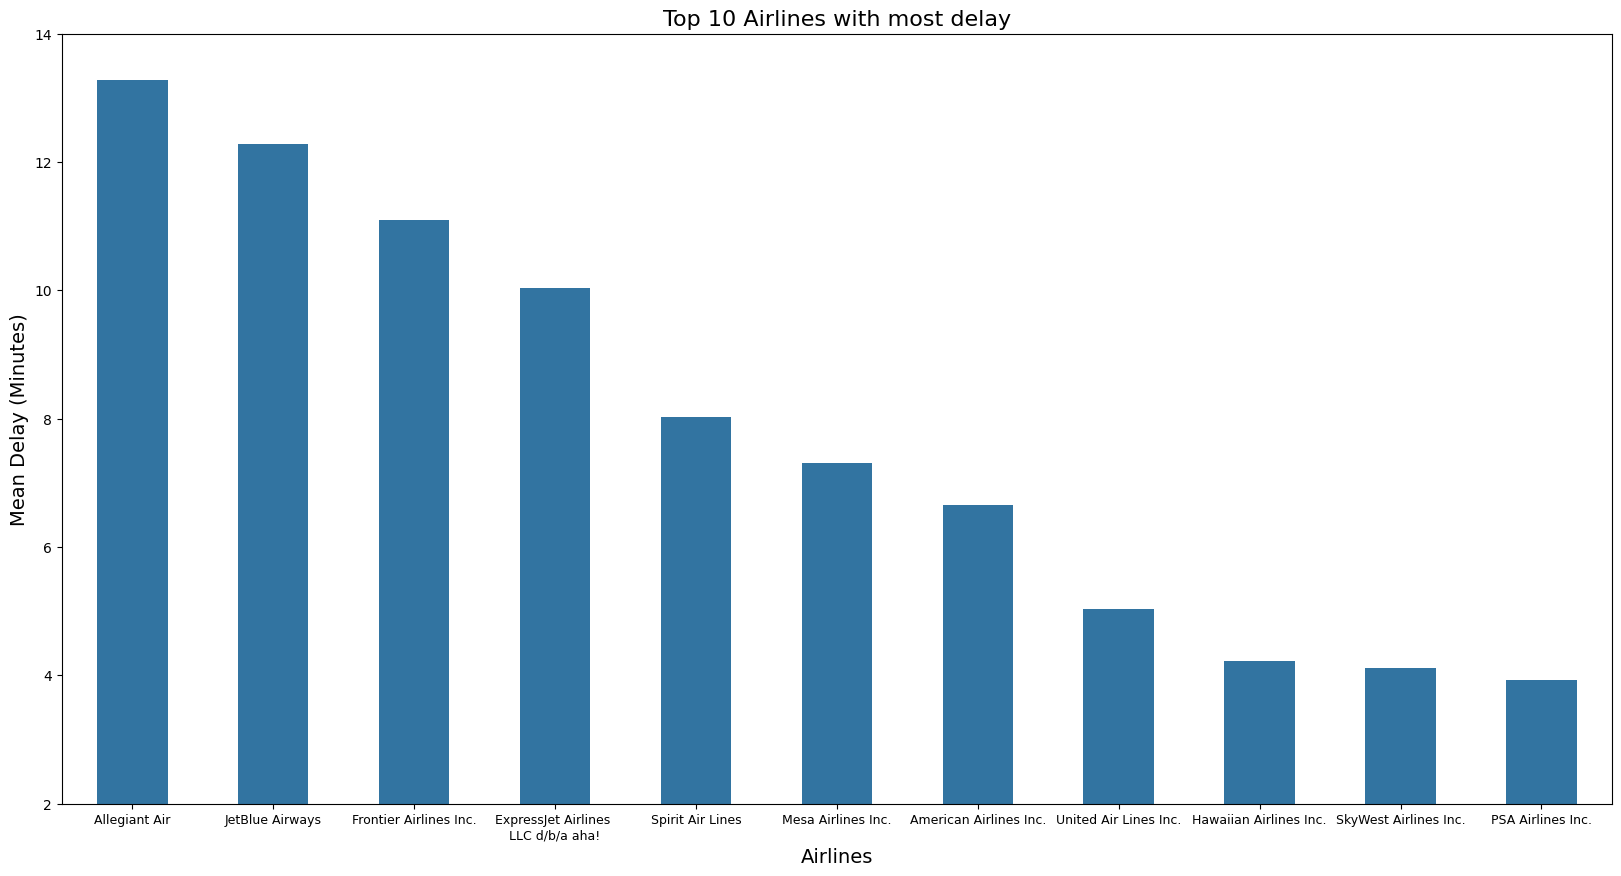

In [51]:
#Top 10 Airlines with most delay
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(1,1,1)
sns.barplot(data=mean_del_air, x='AIRLINE', y='MEAN_DELAY', width=0.5)
sns.set_palette('deep')
ax.set_ylim(2,14)
ax.set_title('Top 10 Airlines with most delay', fontsize=16)
ax.set_xlabel('Airlines', fontsize=14)
ax.set_ylabel('Mean Delay (Minutes)', fontsize=14)
ax.set_xticklabels(['Allegiant Air','JetBlue Airways','Frontier Airlines Inc.',
                    'ExpressJet Airlines \nLLC d/b/a aha!',	'Spirit Air Lines',
                    'Mesa Airlines Inc.','American Airlines Inc.',
                    'United Air Lines Inc.','Hawaiian Airlines Inc.',
                    'SkyWest Airlines Inc.','PSA Airlines Inc.'], fontsize=9)

/tmp/ipython-input-10645453.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(),fontsize=9)
/tmp/ipython-input-10645453.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(),fontsize=9)


(20.0, 110.0)

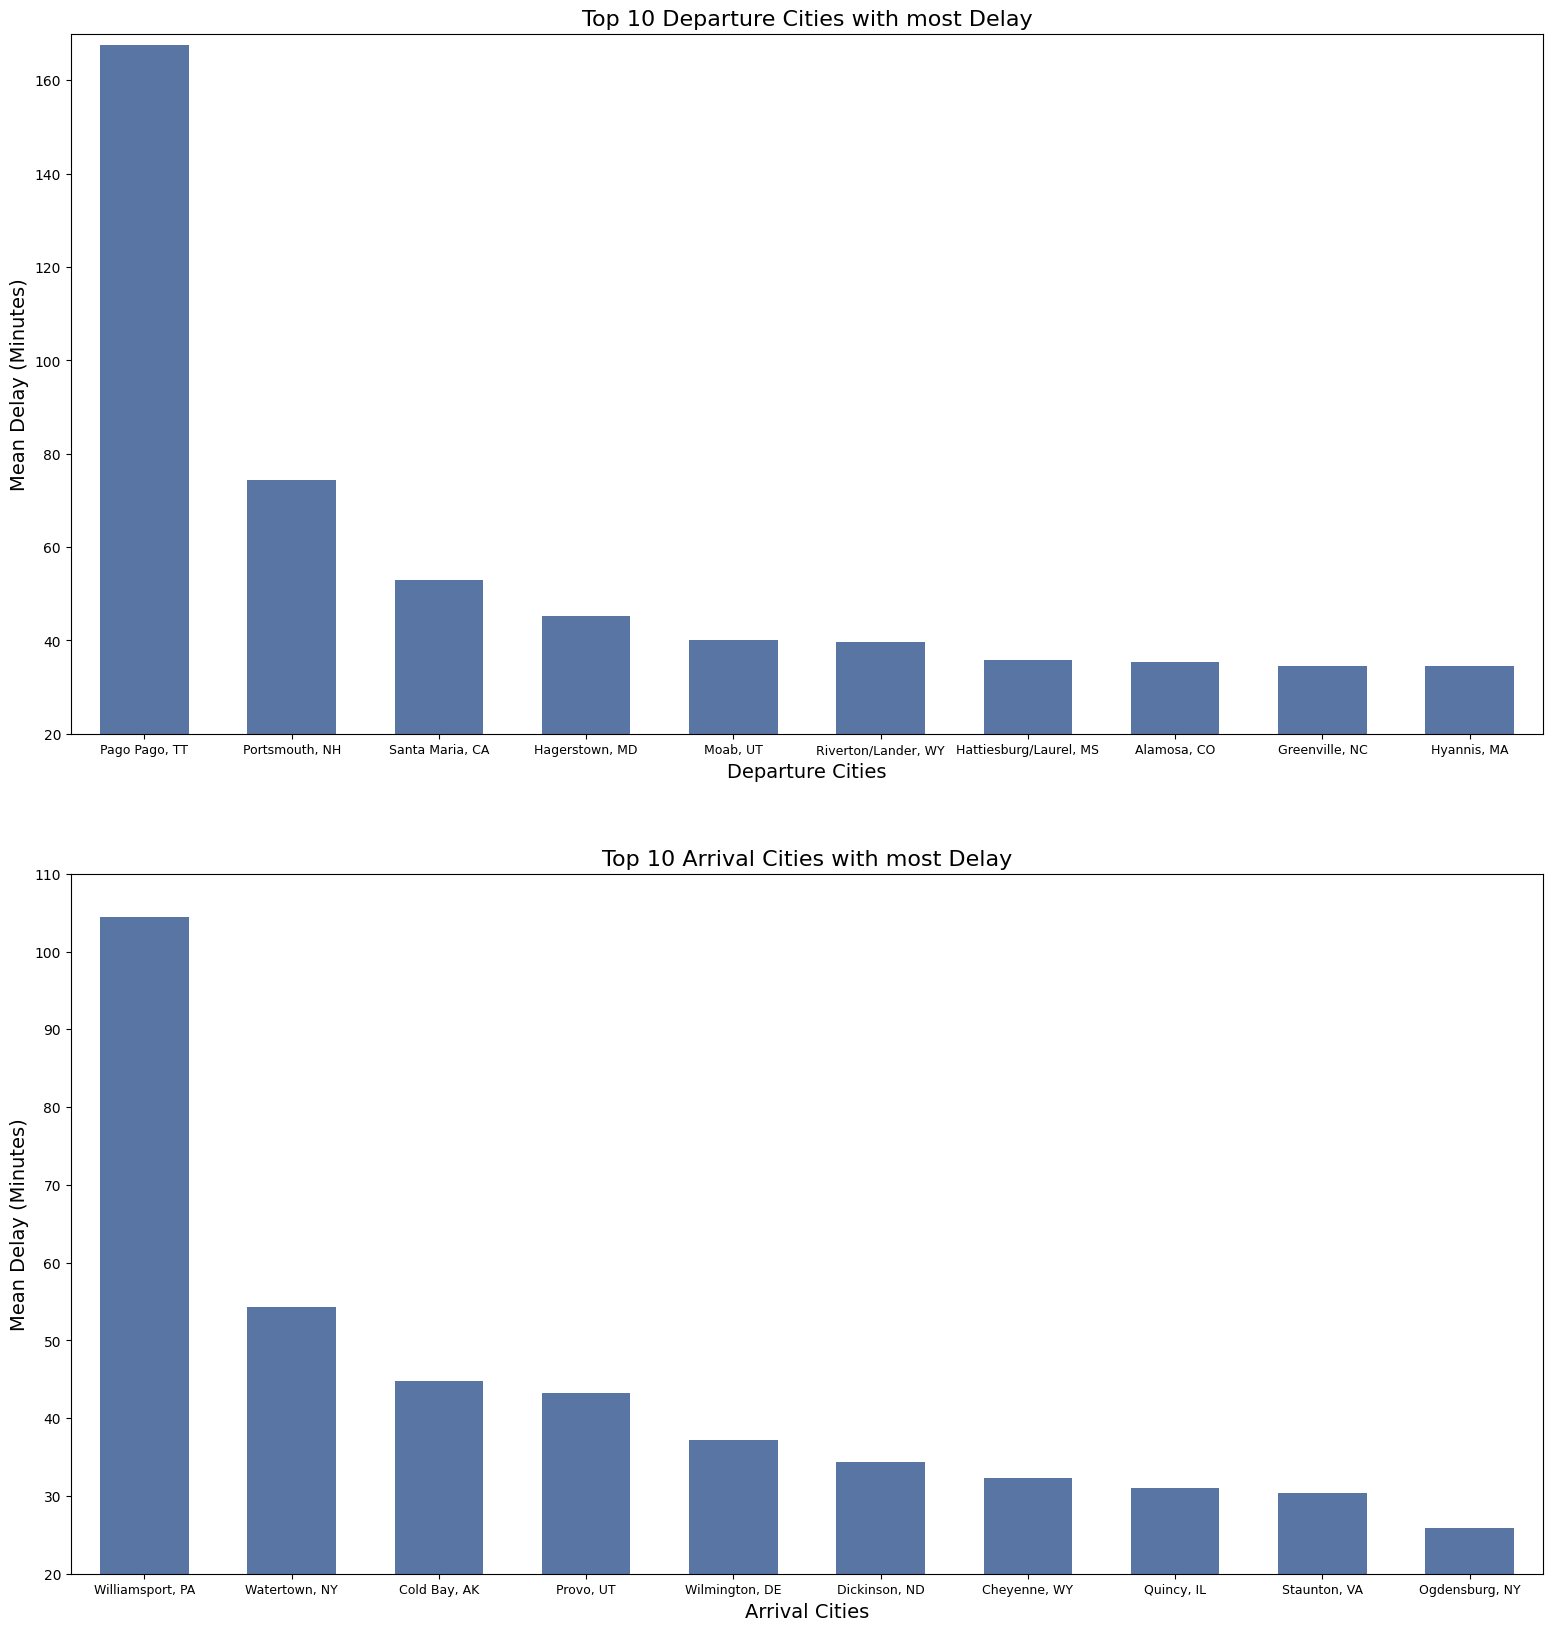

In [52]:
#Biggest Mean Arrival Delay per Departure City (Top 10) &
#Biggest Mean Arrival Delay per Arrival City (Top 10)
fig=plt.figure(figsize=(19,20))
ax1 =fig.add_subplot(2,1,1)
ax2=fig.add_subplot(2,1,2)
sns.set_palette('deep')
sns.barplot(data=most_del_dep,x='ORIGIN_CITY',y='MEAN_DELAY',ax=ax1,width=0.6)
sns.barplot(data=most_del_arr,x='DEST_CITY',y='MEAN_DELAY',ax=ax2,width=0.6)
ax1.set_title('Top 10 Departure Cities with most Delay', fontsize=16)
ax2.set_title('Top 10 Arrival Cities with most Delay', fontsize=16)
ax1.set_xlabel('Departure Cities', fontsize=14)
ax2.set_xlabel('Arrival Cities', fontsize=14)
ax1.set_ylabel('Mean Delay (Minutes)', fontsize=14)
ax2.set_ylabel('Mean Delay (Minutes)', fontsize=14)
ax1.set_xticklabels(ax1.get_xticklabels(),fontsize=9)
ax2.set_xticklabels(ax2.get_xticklabels(),fontsize=9)
ax1.set_ylim(20,170)
ax2.set_ylim(20,110)

/tmp/ipython-input-3542132368.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Sanford, FL-\nGrand Forks, ND',


[Text(0, 0, 'Sanford, FL-\nGrand Forks, ND'),
 Text(1, 0, 'Denver, CO-\nAllentown/Bethlehem/Easton, PA'),
 Text(2, 0, 'St. Petersburg, FL-\nProvo, UT'),
 Text(3, 0, 'Miami, FL-\nHuntsville, AL'),
 Text(4, 0, 'Fort Dodge, IA-\nDenver, CO'),
 Text(5, 0, 'Idaho Falls, ID-\nPortland, OR'),
 Text(6, 0, 'Greer, SC-\nTampa, FL'),
 Text(7, 0, 'Provo, UT-\nSt. Petersburg, FL'),
 Text(8, 0, 'Savannah, GA-\nAkron, OH'),
 Text(9, 0, 'Kalispell, MT-\nNew York, NY')]

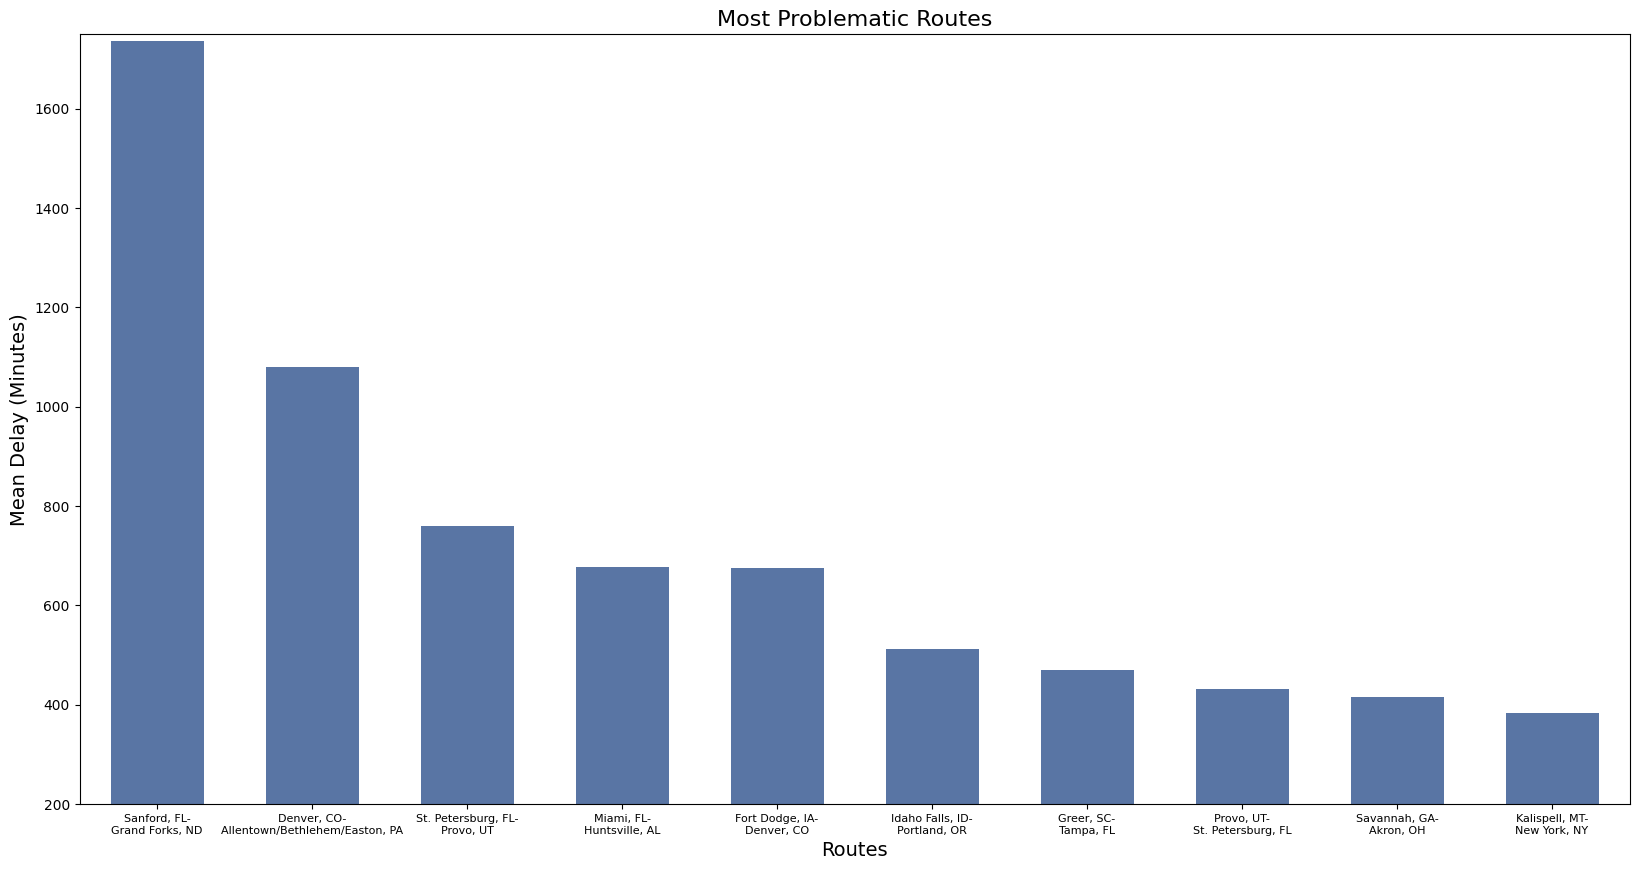

In [53]:
#Most Problematic Routes
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(1,1,1)
sns.barplot(data=most_prob_route,x='ROUTE',y='MEAN_DELAY',width=0.6)
sns.set_palette('deep')
ax.set_title('Most Problematic Routes', fontsize=16)
ax.set_xlabel('Routes', fontsize=14)
ax.set_ylabel('Mean Delay (Minutes)', fontsize=14)
ax.set_ylim(200,1750)
ax.set_xticklabels(['Sanford, FL-\nGrand Forks, ND',
                    'Denver, CO-\nAllentown/Bethlehem/Easton, PA',
	                  'St. Petersburg, FL-\nProvo, UT',
	                  'Miami, FL-\nHuntsville, AL',
	                  'Fort Dodge, IA-\nDenver, CO',
	                  'Idaho Falls, ID-\nPortland, OR',
	                  'Greer, SC-\nTampa, FL',
	                  'Provo, UT-\nSt. Petersburg, FL',
	                  'Savannah, GA-\nAkron, OH',
                    'Kalispell, MT-\nNew York, NY'],fontsize=8)

/tmp/ipython-input-233107511.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])


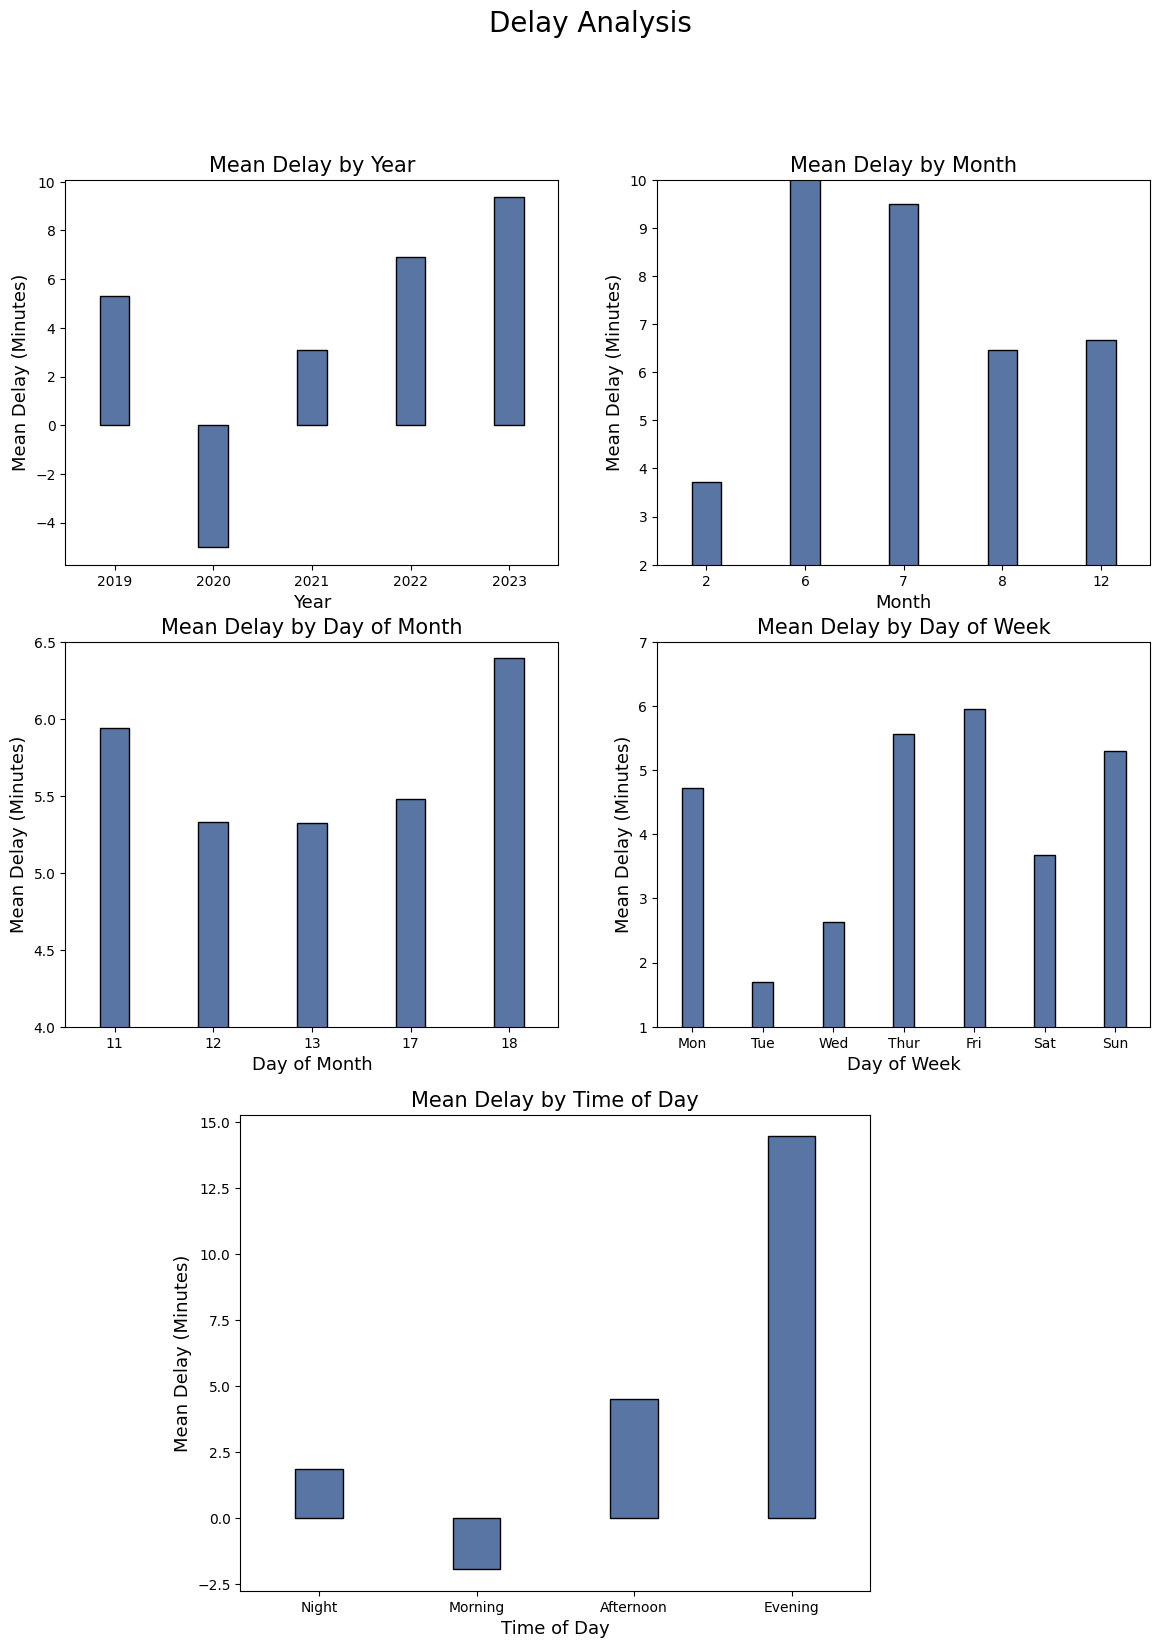

In [65]:
#Most Delay by Time
#Setting up axes
fig=plt.figure(figsize=(14,17))
ax1=fig.add_subplot(3,2,1)
ax2=fig.add_subplot(3,2,2)
ax3=fig.add_subplot(3,2,3)
ax4=fig.add_subplot(3,2,4)
ax5=fig.add_subplot(3,2,5)
#Creating Subplots
sns.barplot(data=mean_del_year,x='YEAR',y='MEAN_DELAY',ax=ax1,width=0.3,
            edgecolor='black')
sns.barplot(data=mean_del_month,x='MONTH',y='MEAN_DELAY',ax=ax2,width=0.3,
            edgecolor='black')
sns.barplot(data=mean_del_day,x='DAY',y='MEAN_DELAY',ax=ax3,width=0.3,
            edgecolor='black')
sns.barplot(data=mean_del_dow,x='DAY_OF_WEEK',y='MEAN_DELAY',ax=ax4,width=0.3,
            edgecolor='black')
sns.barplot(data=mean_del_tod,x='TIME_OF_DAY',y='MEAN_DELAY',ax=ax5,width=0.3,
            edgecolor='black')
sns.set_palette('deep')
#Customizing Text
ax1.set_xlabel('Year', fontsize=13)
ax2.set_xlabel('Month', fontsize=13)
ax3.set_xlabel('Day of Month', fontsize=13)
ax4.set_xlabel('Day of Week', fontsize=13)
ax5.set_xlabel('Time of Day', fontsize=13)
ax1.set_ylabel('Mean Delay (Minutes)', fontsize=13)
ax2.set_ylabel('Mean Delay (Minutes)', fontsize=13)
ax3.set_ylabel('Mean Delay (Minutes)', fontsize=13)
ax4.set_ylabel('Mean Delay (Minutes)', fontsize=13)
ax5.set_ylabel('Mean Delay (Minutes)', fontsize=13)
ax1.set_title('Mean Delay by Year', fontsize=15)
ax2.set_title('Mean Delay by Month', fontsize=15)
ax3.set_title('Mean Delay by Day of Month', fontsize=15)
ax4.set_title('Mean Delay by Day of Week', fontsize=15)
ax5.set_title('Mean Delay by Time of Day', fontsize=15)
fig.suptitle('Delay Analysis', fontsize=20)
#Customizing axxes
ax2.set_ylim(2,10)
ax3.set_ylim(4,6.5)
ax4.set_ylim(1,7)
ax4.set_xticklabels(['Mon','Tue','Wed','Thur','Fri','Sat','Sun'])
ax5.set_position([0.25,0.05,0.45,0.28])

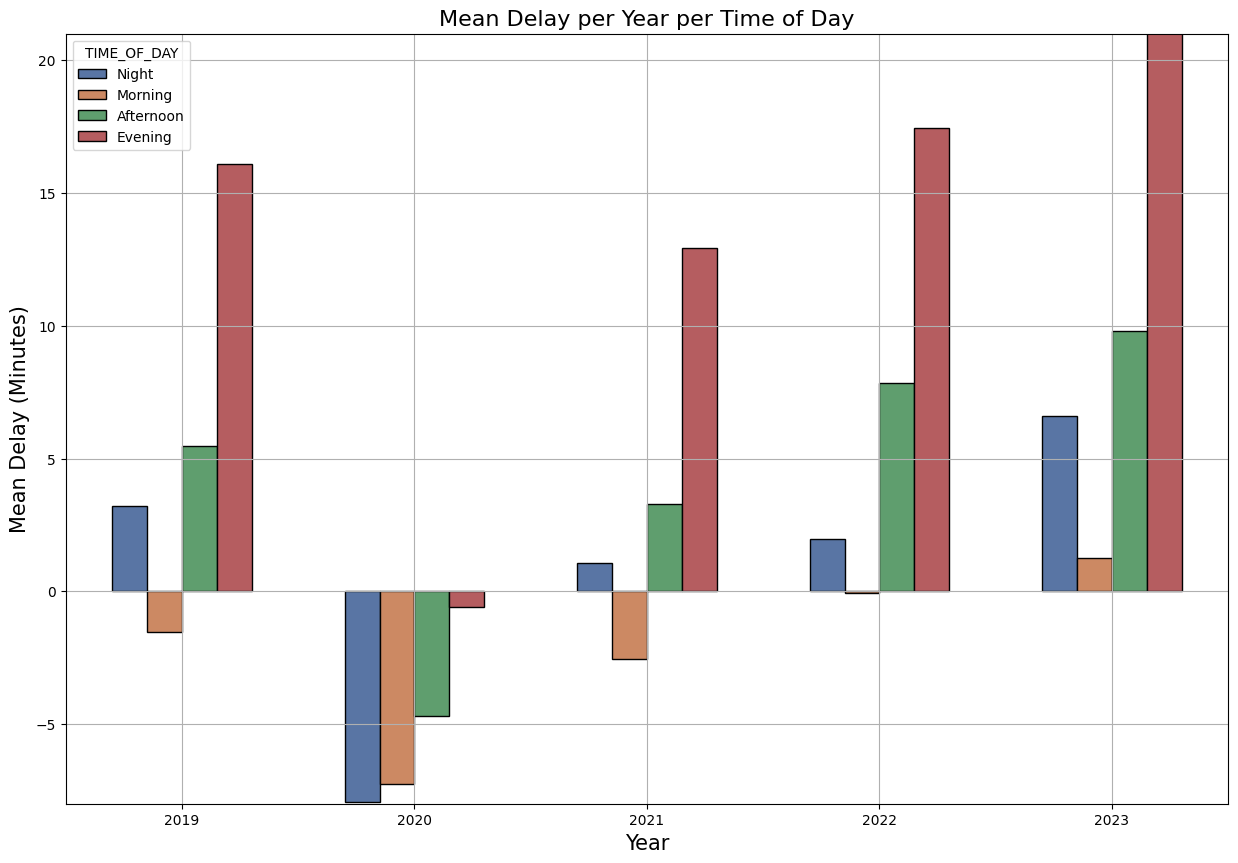

In [55]:
#Mean Delay per Year per Time of Day
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(1,1,1)
sns.set_palette('deep')
sns.barplot(data=mean_del_ytod,x='YEAR',y='MEAN_DELAY',hue='TIME_OF_DAY',
            ax=ax,width=0.6, edgecolor='black')
ax.set_title('Mean Delay per Year per Time of Day', fontsize=16)
ax.set_xlabel('Year', fontsize=15)
ax.set_ylabel('Mean Delay (Minutes)', fontsize=15)
ax.set_ylim(-8,21)
ax.grid()

Text(0, 0.5, 'Total Cancelled Flights')

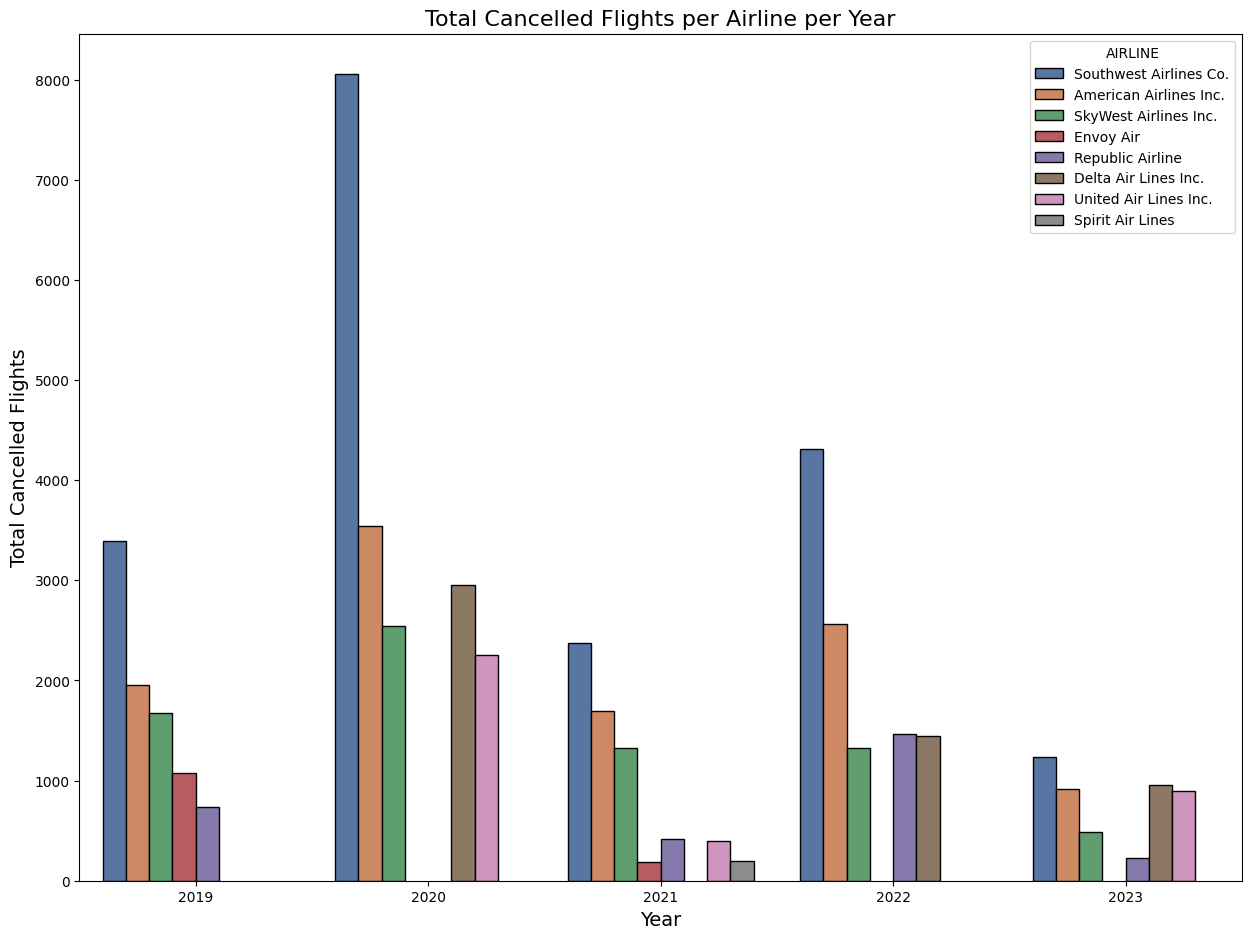

In [66]:
#Total cancelled flights per Airline per Year
fig=plt.figure(figsize=(15,11))
ax=fig.add_subplot(1,1,1)
sns.set_palette('deep')
sns.barplot(data=mean_can_ya,x='YEAR',y='TOTAL_CANCELLED_FLIGHTS',hue='AIRLINE',
            ax=ax,width=0.8, edgecolor='black')
ax.set_title('Total Cancelled Flights per Airline per Year', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Total Cancelled Flights', fontsize=14)

##**Step 7: Conclusion**
Through this explorary data analysis we examined the behaviour of delay (more specifically the `ARR_DELAY`) across years 2019-2023 from a sample of 2.9 million flights. Furthermore we examined the behaviour of total cancelled flight per Year per Airline, more specifically the top 5 each year.

**Key Findings**
*  The Airlines (top 3) with most delay are by the following order:

    1.  Allegiant Air
    2.  JetBlue
    3.  Frontier Airlines
*  The most delay to reach any destination (Top 3) is found if you depart in one of the following cities:
    1. Pago Pago (TT)
    2. Portsmouth (NH)
    3. Santa Maria (CA)
*  The destinations that are the most problematic (Top 3), departing from anywhere are:
    1. Williamsport (PA)
    2. Watertown (NY)  
    3. Coldbay (AK)
*  Delay was negative at 2020 due, which means aircrafts were arriving faster than expected (due to covid), however from 2021 it is constantly increasing.
*  The months with the most delay (Top 3) are:
    1.  June
    2.  July
    3.  December
* Analysis showed that in every month the most delay occurs at the second 10-day window (11-20 of each month)
* The day which has the most delay is Friday and the time of day which max delay is evening (18:00-00:00)
*  There is a decreasing tedency of cancelled flights of Southwest, American and Skywest whhich also have have the most cancelled flights per year.
